<a href="https://colab.research.google.com/github/VinishUchiha/Language_Model/blob/master/Language_Model_Using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, Input, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, SGD

In [0]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 3000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 2000
LATENT_DIM = 25

In [3]:
input_texts = []
target_texts = []
file_path = '/content/robert_frost'
for line in open(file_path):
  line = line.rstrip()
  if not line:
    continue

  input_line = '<sos> '+line
  target_line = line + ' <eos>'

  input_texts.append(input_line)
  target_texts.append(target_line)

all_lines = input_texts + target_texts

#convert sentence into int
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE,filters='')
tokenizer.fit_on_texts(all_lines)
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)

max_seq_length_from_data = max(len(s) for s in input_sequences)
print('Max Seq Length : ',max_seq_length_from_data)

word2idx = tokenizer.word_index
print('Found {} unique tokens.'.format(len(word2idx)))
assert('<sos>' in word2idx)
assert('<eos>' in word2idx)

Max Seq Length :  12
Found 3056 unique tokens.


In [4]:
#Downloading Glove Vector #colab
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-05-20 11:43:05--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-05-20 11:43:05--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-05-20 11:43:05--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [5]:
#unziping #colab
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [6]:
max_seq_len = min(max_seq_length_from_data,MAX_SEQUENCE_LENGTH)
input_sequences = pad_sequences(input_sequences,maxlen=max_seq_len,padding='post')
target_sequences = pad_sequences(target_sequences,maxlen=max_seq_len,padding='post')
print('Shape of data tensor : ',input_sequences.shape)

Shape of data tensor :  (1436, 12)


In [7]:
#load pre-trained vectors
word2vec = {}
with open(os.path.join('/content/glove.6B.50d.txt')) as f:
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:],dtype='float32')
    word2vec[word] = vec
print('Found {} word vectors'.format(len(word2vec)))

Found 400000 word vectors


In [0]:
#prepare embedding matrix
num_words = min(MAX_VOCAB_SIZE,len(word2idx)+1)
embedding_matrix = np.zeros((num_words,EMBEDDING_DIM))
for word,i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [0]:
#one-hot the target
one_hot_targets = np.zeros((len(input_sequences),max_seq_len,num_words))
for i, target_sequence in enumerate(target_sequences):
  for t, word in enumerate(target_sequence):
    if word > 0:
      one_hot_targets[i,t,word] = 1

In [0]:
#load pre-trained word embedding to embedding layer
embedding_layer = Embedding(num_words,EMBEDDING_DIM,weights=[embedding_matrix])
#Model building
input_ = Input(shape=(max_seq_len,))
initial_h = Input(shape=(LATENT_DIM,))
initial_c = Input(shape=(LATENT_DIM,))
x = embedding_layer(input_)
lstm = LSTM(LATENT_DIM,return_sequences=True,return_state=True)
x,_,_ = lstm(x,initial_state=[initial_h,initial_c])
dense = Dense(num_words,activation='softmax')
output = dense(x)

model = Model([input_,initial_h,initial_c],output)
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.01),metrics=['accuracy'])

In [0]:
model.summary()

In [0]:
#Training a Model
z = np.zeros((len(input_sequences),LATENT_DIM))
r = model.fit([input_sequences,z,z],one_hot_targets,batch_size=BATCH_SIZE,epochs=EPOCHS,
              validation_split = VALIDATION_SPLIT)

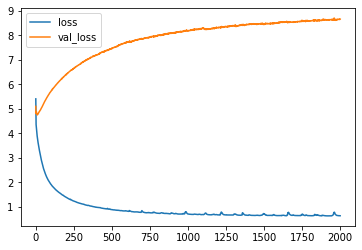

In [13]:
#ploting the loss
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

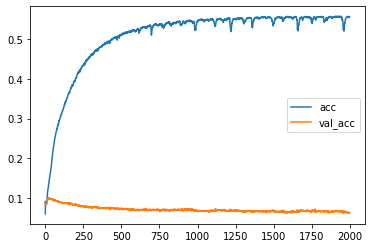

In [15]:
#ploting the acc
plt.plot(r.history['accuracy'],label='acc')
plt.plot(r.history['val_accuracy'],label='val_acc')
plt.legend()
plt.show()

In [0]:
#make a sampling model
input2 = Input(shape=(1,)) #one word at a time
x = embedding_layer(input2)
x,h,c = lstm(x,initial_state=[initial_h,initial_c])
output2 = dense(x)
sampling_model = Model([input2,initial_h,initial_c],[output2,h,c])

In [0]:
idx2word = {v:k for k,v in word2idx.items()}

In [0]:
def sample_line():
  np_input = np.array([[word2idx['<sos>']]])
  h = np.zeros((1,LATENT_DIM))
  c = np.zeros((1,LATENT_DIM))

  eos = word2idx['<eos>']

  output_sentence = []

  for _ in range(max_seq_len):
    o,h,c = sampling_model.predict([np_input,h,c])

    probs = o[0,0]
    if np.argmax(probs) == 0:
      print('Impossible')
    probs[0] = 0
    probs /= probs.sum()
    idx = np.random.choice(len(probs),p=probs)
    if idx ==eos:
      break

    output_sentence.append(idx2word.get(idx,'MISSING'))

    #MAKE THE NEXT INPUT INTO MODEL
    np_input[0,0] = idx

  return ' '.join(output_sentence)

In [0]:
while True:
  for _ in range(4):
    print(sample_line())

  ans = input('Generate Another?? [y/n]')
  if ans and ans[0].lower().startswith('n'):
    break